# Anomaly Detection Model for Healthcare Device Data



In [12]:
import os
import pandas as pd

# Define the folder containing the processed data
processed_data_folder = "../processed_data"

# Load all patient DataFrame .pkl files
patient_dataframes = {}
for file in os.listdir(processed_data_folder):
    if file.endswith("_processed.pkl"):
        patient_id = file.split("_")[0]  # Extract patient ID from the filename
        patient_dataframes[patient_id] = pd.read_pickle(os.path.join(processed_data_folder, file))

# Example: Print the keys (patient IDs) and the first few rows of one DataFrame
print(f"Loaded patient IDs: {list(patient_dataframes.keys())}")
print(patient_dataframes[list(patient_dataframes.keys())[0]].head())

Loaded patient IDs: ['S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
   bvp_mean    bvp_std    bvp_energy     bvp_ptp            bvp_freq_1  \
0 -3.120449  97.081244  2.415233e+06  781.477358  [15.237045471108313]   
1 -1.325391  97.497728  2.433936e+06  781.511716   [1.724030308405311]   
2 -0.445313  97.592194  2.438255e+06  781.509878  [12.279975717297718]   
3 -0.223027  97.597714  2.438493e+06  781.545981  [18.662209905605682]   
4  3.138984  18.017857  8.563108e+04   79.709171    [27.3308483912108]   

             bvp_freq_2            bvp_freq_3  bvp_skewness  bvp_kurtosis  \
0    [4.28060767761561]   [6.076547474360892]     -2.914617     13.051342   
1   [9.573453129335247]   [9.655299243621165]     -2.929738     12.993734   
2  [26.098770576458392]  [27.022712527519346]     -2.947966     13.037922   
3   [34.08213309207644]   [47.48653642239944]     -2.954025     13.061178   
4  [43.155205345463806]  [37.425938193693035]     -0.

In [3]:
print(patient_dataframes['S1'].columns.tolist())

['bvp_mean', 'bvp_std', 'bvp_energy', 'bvp_ptp', 'bvp_freq_1', 'bvp_freq_2', 'bvp_freq_3', 'bvp_skewness', 'bvp_kurtosis', 'acc_x_mean', 'acc_x_std', 'acc_y_mean', 'acc_y_std', 'acc_z_mean', 'acc_z_std', 'acc_magnitude_mean', 'acc_magnitude_std', 'bvp_acc_corr_mean', 'temp_mean', 'temp_std', 'temp_range', 'activity', 'bpm']


In [65]:
from sklearn.ensemble import IsolationForest
import pandas as pd

# Combine all patient data into a single DataFrame
combined_data = pd.concat(
    [df.assign(patient_id=patient_id) for patient_id, df in patient_dataframes.items()],
    ignore_index=True
)
# Select numerical columns for anomaly detection
numerical_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop("activity")  # Exclude the activity column
X = combined_data[numerical_columns]

# Initialize and fit Isolation Forest
isolation_forest = IsolationForest(n_estimators=500, contamination=0.01, random_state=42)
combined_data['anomaly'] = isolation_forest.fit_predict(X)

# Save anomalies for analysis
anomalies = combined_data[combined_data['anomaly'] == -1]
print(f"Number of anomalies detected: {len(anomalies)}")

Number of anomalies detected: 647


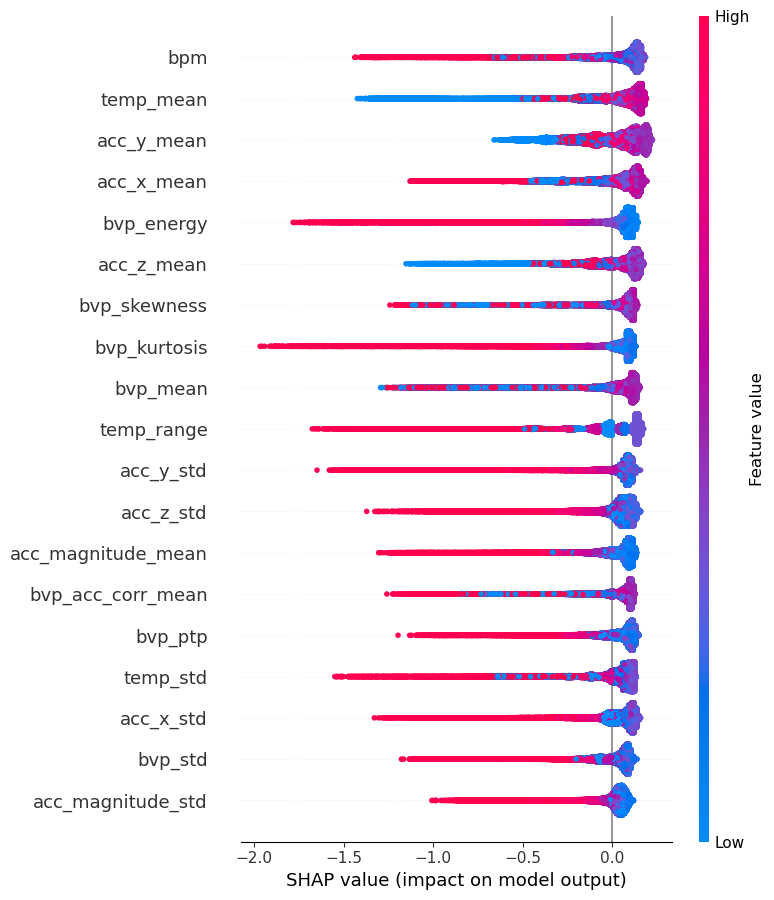

In [125]:
from sklearn.ensemble import IsolationForest
import shap
import pandas as pd

# Combine all patient data into a single DataFrame
combined_data = pd.concat(patient_dataframes.values(), ignore_index=True)

# Select numerical columns for anomaly detection, excluding the activity label
numerical_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop("activity")  # Exclude the activity column
X = combined_data[numerical_columns]

# Initialize and fit Isolation Forest
isolation_forest = IsolationForest(n_estimators=500, contamination=0.01, random_state=42)
isolation_forest.fit(X)

# Summarize the background data using shap.sample or shap.kmeans
background_data = shap.sample(X, 1000)  # Use 100 samples as the background data
# Alternatively, you can use shap.kmeans(X, 100) for clustering-based summarization

# Use SHAP to explain the anomaly scores
explainer = shap.TreeExplainer(isolation_forest)
shap_values = explainer.shap_values(X)

# Visualize feature importance
shap.summary_plot(shap_values, X)

## Compare Results with Other Algorithms

To increase confidence in our results, given that we are using unlabeled data, it was decided to implement another algorithm for this project to compare results.

In [120]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=160, contamination=0.01)
lof_labels = lof.fit_predict(X)

lof_anomalies = combined_data[lof_labels == -1]

# Compare with Isolation Forest results
print(f"Number of anomalies detected by LOF: {len(lof_anomalies)}")
print(f"Overlap with Isolation Forest anomalies: {len(set(anomalies.index) & set(lof_anomalies.index))}")

Number of anomalies detected by LOF: 647
Overlap with Isolation Forest anomalies: 237


## Evaluation Using Proxy Metrics

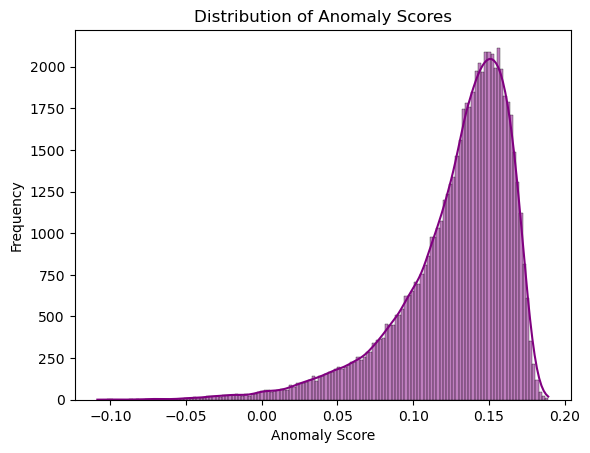

In [121]:
# Get anomaly scores
anomaly_scores = isolation_forest.decision_function(X)

# Plot the distribution of anomaly scores
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(anomaly_scores, kde=True, color="purple")
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

## Correlation with Anomaly Labels

Instead


In [123]:
# Compute correlations between features and anomaly labels
correlations = combined_data[numerical_columns].corrwith(combined_data["anomaly"])
print("Feature Correlations with Anomaly Label:\n", correlations)

# Plot correlations
correlations.sort_values().plot(kind="bar", title="Feature Correlations with Anomaly Label")
plt.show()

KeyError: 'anomaly'

## Statistical Analysis of Anomalies

Checked to see proportion of anomalies across the 15 patients

patient_id
S1      31
S2      39
S3      37
S4      10
S5     139
S6       9
S7       1
S8      77
S9     144
S10      3
S11     10
S12     87
S13     15
S14     45
dtype: int64


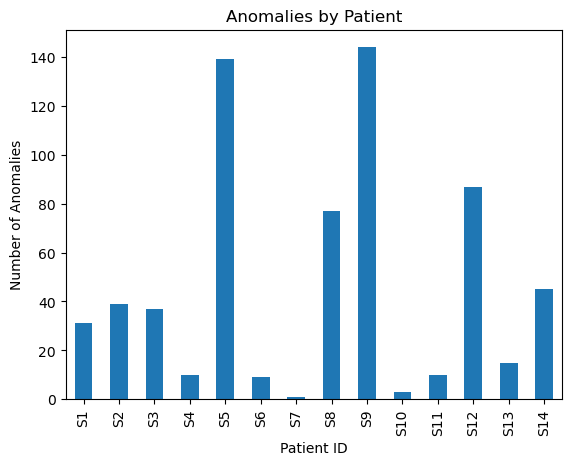

In [66]:
import matplotlib.pyplot as plt

# Count anomalies by patient
anomalies_by_patient = combined_data[combined_data["anomaly"] == -1].groupby("patient_id").size()

# Sort patient IDs numerically by extracting the numeric part
anomalies_by_patient = anomalies_by_patient.sort_index(key=lambda x: x.str.extract(r'(\d+)').astype(int)[0])

# Print and plot the anomalies by patient
print(anomalies_by_patient)
anomalies_by_patient.plot(kind="bar", title="Anomalies by Patient")
plt.xlabel("Patient ID")
plt.ylabel("Number of Anomalies")
plt.show()

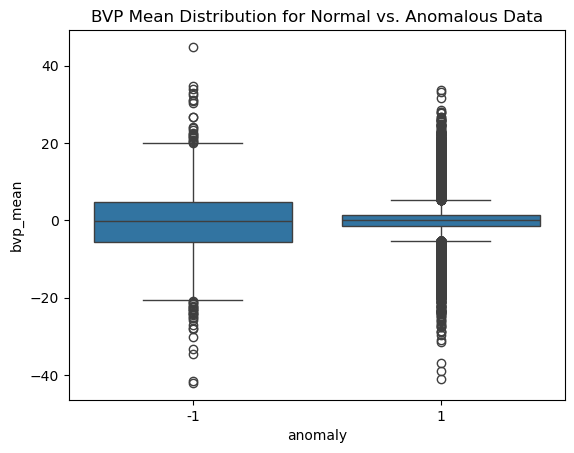

## Temporal Analysis

Analyze how anomalies are distributed across each patient based on activity levels

Anomaly count per activity:
activity
0.0    193
2.0     19
3.0     54
4.0    194
5.0     40
6.0     35
7.0     72
8.0     40
dtype: int64


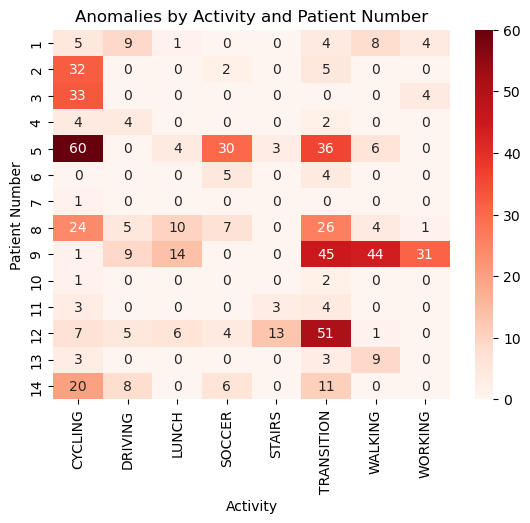

In [73]:
# Extract patient numbers from patient_id
combined_data["patient_number"] = combined_data["patient_id"].str.extract(r'(\d+)').astype(int)

# Define the activity mapping
activity_mapping = {
    "TRANSITION": 0,
    "SITTING": 1,
    "STAIRS": 2,
    "SOCCER": 3,
    "CYCLING": 4,
    "DRIVING": 5,
    "LUNCH": 6,
    "WALKING": 7,
    "WORKING": 8,
}

# Reverse the mapping to map numbers to names
activity_mapping_reverse = {v: k for k, v in activity_mapping.items()}

# Map activity numbers to activity names in the combined_data DataFrame
combined_data["activity_name"] = combined_data["activity"].map(activity_mapping_reverse)

# Count anomalies by activity name for each patient number
anomalies_by_activity_patient = combined_data[combined_data["anomaly"] == -1].groupby(["patient_number", "activity_name"]).size().unstack(fill_value=0)

# Plot a heatmap of anomalies by activity name and patient number
import seaborn as sns
import matplotlib.pyplot as plt

# Count anomalies by activity
anomalies_by_activity = combined_data[combined_data["anomaly"] == -1].groupby("activity").size()

# Log the anomaly count per activity
print("Anomaly count per activity:")
print(anomalies_by_activity)

sns.heatmap(anomalies_by_activity_patient, cmap="Reds", annot=True, fmt="d")
plt.title("Anomalies by Activity and Patient Number")
plt.ylabel("Patient Number")
plt.xlabel("Activity")
plt.show()

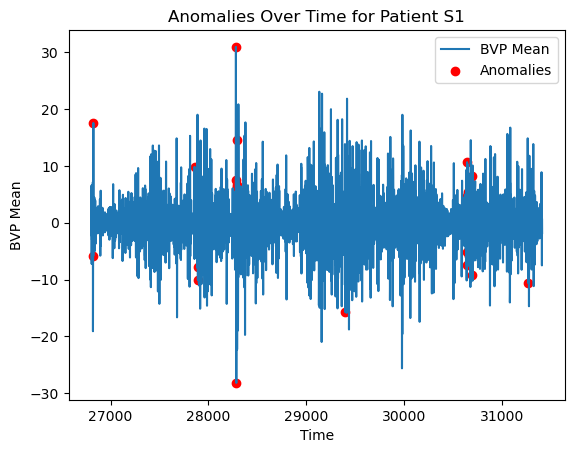

In [74]:
# Plot anomalies over time for a specific patient
patient_id = "S1"  # Replace with a specific patient ID
patient_data = combined_data[combined_data["patient_id"] == patient_id]

plt.plot(patient_data.index, patient_data["bvp_mean"], label="BVP Mean")
plt.scatter(
    patient_data[patient_data["anomaly"] == -1].index,
    patient_data[patient_data["anomaly"] == -1]["bvp_mean"],
    color="red", label="Anomalies"
)
plt.title(f"Anomalies Over Time for Patient {patient_id}")
plt.xlabel("Time")
plt.ylabel("BVP Mean")
plt.legend()
plt.show()

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


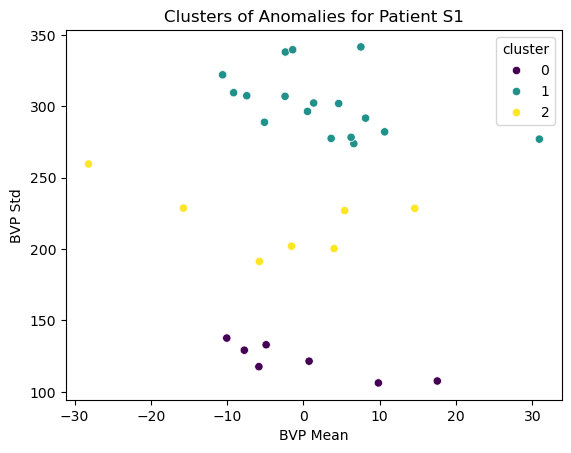

In [75]:
from sklearn.cluster import KMeans

# Filter anomalies for a specific patient
patient_anomalies = combined_data[(combined_data["patient_id"] == "S1") & (combined_data["anomaly"] == -1)]

# Perform clustering on anomalies
kmeans = KMeans(n_clusters=3, random_state=42)
patient_anomalies["cluster"] = kmeans.fit_predict(patient_anomalies[numerical_columns])

# Visualize clusters
sns.scatterplot(data=patient_anomalies, x="bvp_mean", y="bvp_std", hue="cluster", palette="viridis")
plt.title("Clusters of Anomalies for Patient S1")
plt.xlabel("BVP Mean")
plt.ylabel("BVP Std")
plt.show()

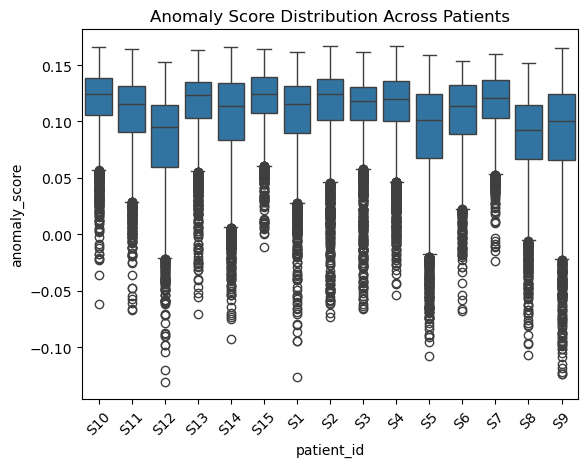

In [46]:
# Add anomaly scores to the combined data
combined_data["anomaly_score"] = isolation_forest.decision_function(X)

# Plot the distribution of anomaly scores for each patient
sns.boxplot(data=combined_data, x="patient_id", y="anomaly_score")
plt.title("Anomaly Score Distribution Across Patients")
plt.xticks(rotation=45)
plt.show()

In [24]:
# Compute correlations between features and anomaly labels for each patient
correlations = combined_data.groupby("patient_id").apply(
    lambda df: df[numerical_columns].corrwith(df["anomaly"])
)

# Display correlations for a specific patient
print(correlations.loc["S1"])  # Replace "S1" with a specific patient ID

bvp_mean             -0.010675
bvp_std              -0.310639
bvp_energy           -0.385706
bvp_ptp              -0.349914
bvp_skewness          0.025505
bvp_kurtosis         -0.235724
acc_x_mean            0.026758
acc_x_std            -0.415556
acc_y_mean           -0.044700
acc_y_std            -0.237158
acc_z_mean            0.016808
acc_z_std            -0.282905
acc_magnitude_mean   -0.376914
acc_magnitude_std    -0.242145
bvp_acc_corr_mean    -0.006601
temp_mean             0.177016
temp_std             -0.211990
temp_range           -0.206735
bpm                  -0.190701
Name: S1, dtype: float64


## Patient Level Anomalies (heart rate, temperature, etc.)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



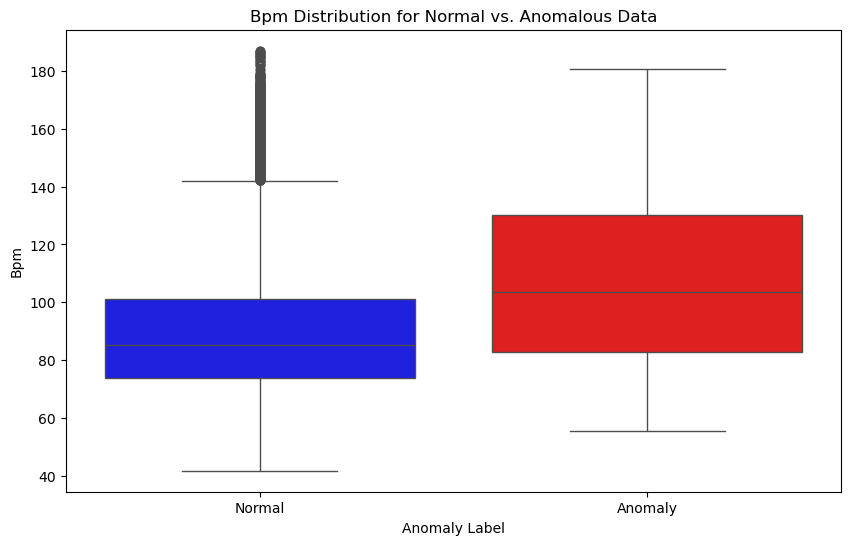



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



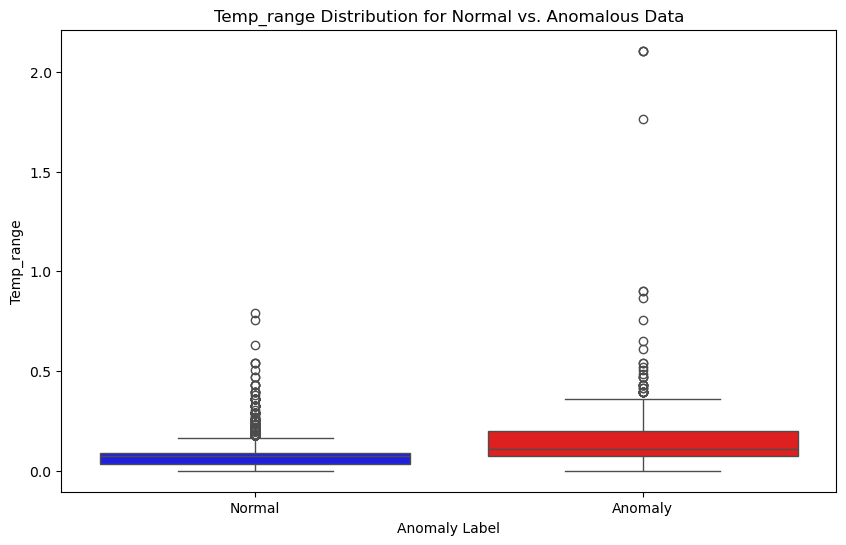

Summary statistics for bpm (Anomalies):
count    647.000000
mean     107.945939
std       30.681172
min       55.361742
25%       82.609364
50%      103.550211
75%      130.078135
max      180.832961
Name: bpm, dtype: float64

Summary statistics for temp_range (Anomalies):
count    647.000000
mean       0.154655
std        0.190965
min        0.000000
25%        0.072000
50%        0.108000
75%        0.198000
max        2.106000
Name: temp_range, dtype: float64



In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map anomaly labels to strings for better compatibility
combined_data["anomaly_label"] = combined_data["anomaly"].map({1: "Normal", -1: "Anomaly"})

# Filter anomalies
anomalies = combined_data[combined_data["anomaly"] == -1]

# Select specific features to analyze (e.g., bpm and temperature)
features_to_analyze = ["bpm", "temp_range"]

# Plot anomalies for each feature
for feature in features_to_analyze:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=combined_data, x="anomaly_label", y=feature, palette={"Normal": "blue", "Anomaly": "red"})
    plt.title(f"{feature.capitalize()} Distribution for Normal vs. Anomalous Data")
    plt.xlabel("Anomaly Label")
    plt.ylabel(feature.capitalize())
    plt.show()

# Optionally, print summary statistics for anomalies
for feature in features_to_analyze:
    print(f"Summary statistics for {feature} (Anomalies):")
    print(anomalies[feature].describe())
    print()

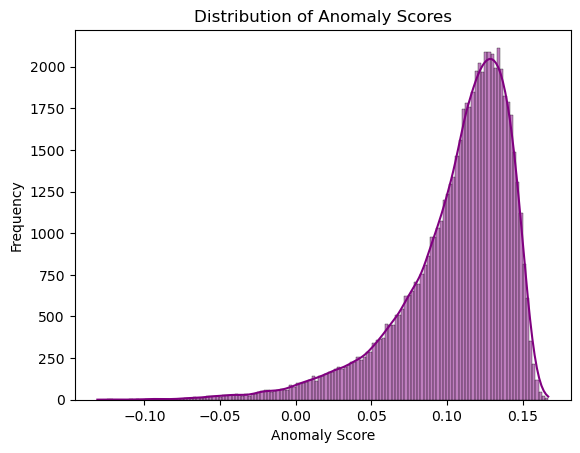

In [47]:
# Get anomaly scores
anomaly_scores = isolation_forest.decision_function(X)

# Plot the distribution of anomaly scores
sns.histplot(anomaly_scores, kde=True, color="purple")
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

In [25]:
# Summary statistics for normal and anomalous data
normal_data = combined_data[combined_data["anomaly"] == 1]
anomalous_data = combined_data[combined_data["anomaly"] == -1]

print("Normal Data Statistics:")
print(normal_data.describe())

print("\nAnomalous Data Statistics:")
print(anomalous_data.describe())

Normal Data Statistics:
           bvp_mean       bvp_std    bvp_energy       bvp_ptp  bvp_skewness  \
count  61462.000000  61462.000000  6.146200e+04  61462.000000  61462.000000   
mean       0.010456     65.996306  1.544082e+06    367.071103     -0.233198   
std        3.428301     40.796227  1.960827e+06    249.385714      0.583312   
min      -37.013867      1.550329  6.186338e+02      8.231760     -4.025672   
25%       -1.305625     35.895288  3.305312e+05    177.676730     -0.552516   
50%       -0.012363     56.872068  8.300547e+05    302.753745     -0.260547   
75%        1.312524     87.745035  1.975744e+06    500.643537      0.079455   
max       33.239609    315.235399  2.546219e+07   1600.469964      4.903802   

       bvp_kurtosis    acc_x_mean     acc_x_std    acc_y_mean     acc_y_std  \
count  61462.000000  61462.000000  61462.000000  61462.000000  61462.000000   
mean       0.913943     -0.528575      0.166566      0.099274      0.179914   
std        2.247284      0.

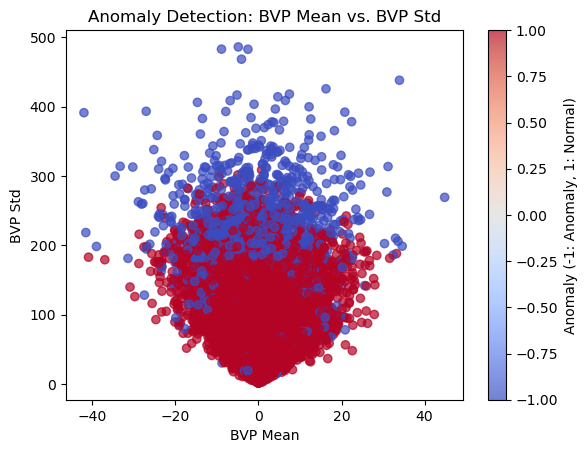

In [48]:
import matplotlib.pyplot as plt

# Scatter plot of BVP Mean vs. BVP Std
plt.scatter(combined_data["bvp_mean"], combined_data["bvp_std"], c=combined_data["anomaly"], cmap="coolwarm", alpha=0.7)
plt.xlabel("BVP Mean")
plt.ylabel("BVP Std")
plt.title("Anomaly Detection: BVP Mean vs. BVP Std")
plt.colorbar(label="Anomaly (-1: Anomaly, 1: Normal)")
plt.show()

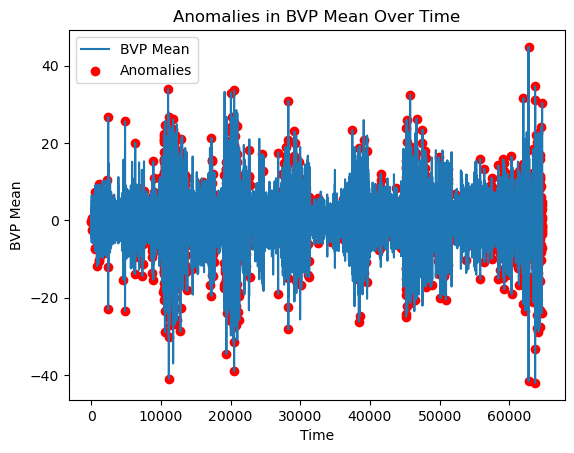

In [19]:
# Time-series plot of BVP Mean with anomalies
plt.plot(combined_data.index, combined_data["bvp_mean"], label="BVP Mean")
plt.scatter(combined_data[combined_data["anomaly"] == -1].index, 
            combined_data[combined_data["anomaly"] == -1]["bvp_mean"], 
            color="red", label="Anomalies")
plt.xlabel("Time")
plt.ylabel("BVP Mean")
plt.title("Anomalies in BVP Mean Over Time")
plt.legend()
plt.show()

The figure layout has changed to tight


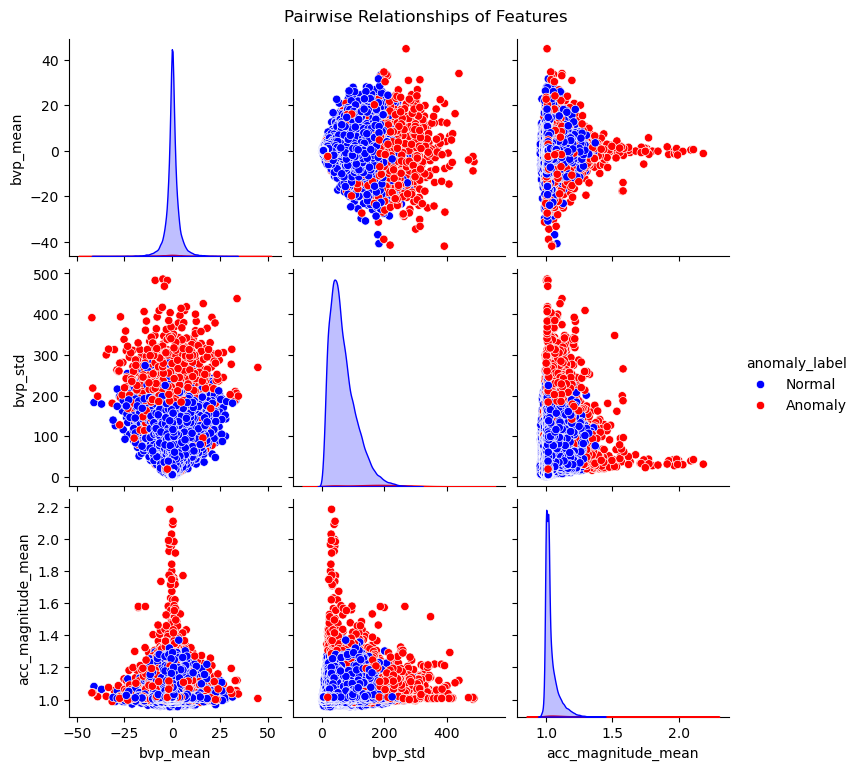

In [49]:
import seaborn as sns

# Add anomaly labels for visualization
combined_data["anomaly_label"] = combined_data["anomaly"].map({1: "Normal", -1: "Anomaly"})

# Pairplot of selected features
sns.pairplot(combined_data, vars=["bvp_mean", "bvp_std", "acc_magnitude_mean"], hue="anomaly_label", palette={"Normal": "blue", "Anomaly": "red"})
plt.suptitle("Pairwise Relationships of Features", y=1.02)
plt.show()

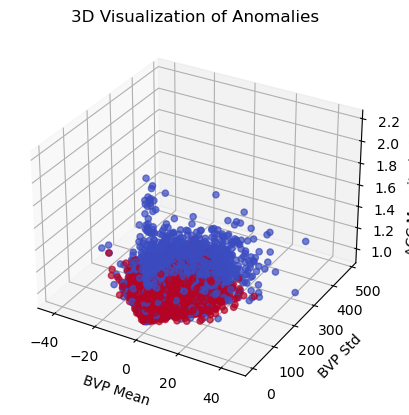

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(combined_data["bvp_mean"], combined_data["bvp_std"], combined_data["acc_magnitude_mean"], 
           c=combined_data["anomaly"], cmap="coolwarm", alpha=0.7)
ax.set_xlabel("BVP Mean")
ax.set_ylabel("BVP Std")
ax.set_zlabel("ACC Magnitude Mean")
plt.title("3D Visualization of Anomalies")
plt.show()

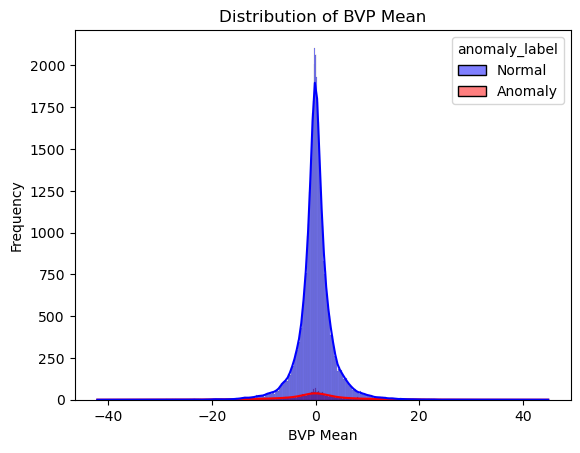

In [22]:
sns.histplot(data=combined_data, x="bvp_mean", hue="anomaly_label", kde=True, palette={"Normal": "blue", "Anomaly": "red"})
plt.title("Distribution of BVP Mean")
plt.xlabel("BVP Mean")
plt.ylabel("Frequency")
plt.show()

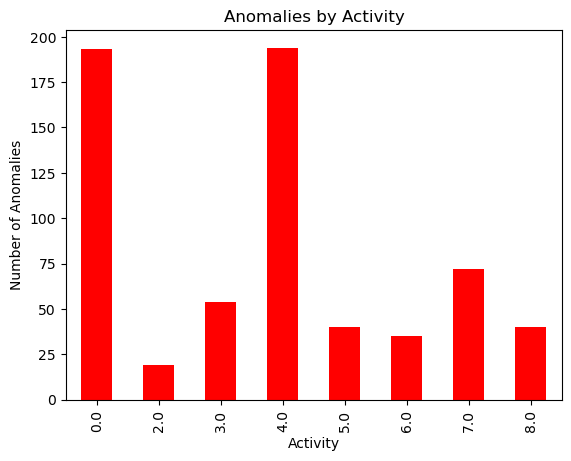

In [76]:
# Count anomalies by activity
anomalies_by_activity = combined_data[combined_data["anomaly"] == -1].groupby("activity").size()

# Bar plot of anomalies by activity
anomalies_by_activity.plot(kind="bar", color="red")
plt.title("Anomalies by Activity")
plt.xlabel("Activity")
plt.ylabel("Number of Anomalies")
plt.show()

Since you are working with **unlabeled data** and using an **unsupervised learning approach** like Isolation Forest, validation and evaluation can be challenging but still achievable. Here are some strategies to validate and evaluate your anomaly detection framework:

---


### **2. Statistical Analysis of Anomalies**
- **Compare Anomalies Across Patients**:
  - Check if the proportion of anomalies is consistent across patients. Significant deviations might indicate false positives or issues with the algorithm.
- **Analyze Feature Distributions**:
  - Compare the distributions of features for normal and anomalous data points. Anomalies should exhibit distinct patterns or outliers in key features.

---

### **3. Evaluate with Proxy Metrics**
Even without labels, you can use the following metrics to evaluate the Isolation Forest's performance:

- **Reconstruction Error**:
  - Calculate the reconstruction error (e.g., mean squared error) for the detected anomalies. Anomalies should have higher reconstruction errors compared to normal data points.
  
- **Isolation Scores**:
  - Analyze the anomaly scores produced by the Isolation Forest. Higher scores should correspond to more isolated (anomalous) points.

---


### **5. Clustering for Validation**
- Apply clustering algorithms (e.g., k-means or DBSCAN) to group the data points. Check if the anomalies detected by the Isolation Forest form distinct clusters or are far from the main clusters.

---




### **8. Visualization**
- Use visualizations to validate anomalies:
  - **Scatter Plots**: Plot key features (e.g., `bvp_mean` vs. `bvp_std`) and color-code anomalies.
  - **Time-Series Plots**: Highlight anomalies on time-series plots of features like heart rate or accelerometer magnitude.
  - **3D Plots**: Visualize anomalies in a 3D space using three key features.

---


---

### **Conclusion**
While the lack of labels makes evaluation more challenging, combining **domain knowledge**, **statistical analysis**, and **proxy metrics** can help validate and refine your anomaly detection framework. Additionally, injecting synthetic anomalies and comparing results with other algorithms can provide further insights into the effectiveness of your approach.

Between **DBSCAN** and **Local Outlier Factor (LOF)**, here's a comparison to help you decide which is better for your project:

---

### **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**
- **Strengths**:
  - Identifies clusters and treats points that don't belong to any cluster as anomalies.
  - Works well if your data has distinct clusters and anomalies are far from these clusters.
  - No need to specify the number of clusters in advance.
- **Challenges**:
  - Requires tuning of `eps` (neighborhood radius) and `min_samples` (minimum points in a cluster).
  - May struggle with high-dimensional data or datasets without clear clusters.
- **Use Case**:
  - Best if your data has natural clusters and anomalies are expected to be isolated from these clusters.

---

### **LOF (Local Outlier Factor)**
- **Strengths**:
  - Measures the "local density" of data points and identifies anomalies as points with significantly lower density compared to their neighbors.
  - Effective for datasets where anomalies are not globally isolated but are locally sparse.
  - Automatically provides anomaly scores for each point.
- **Challenges**:
  - Sensitive to the choice of `n_neighbors` (number of neighbors to consider).
  - Computationally expensive for large datasets.
- **Use Case**:
  - Best if anomalies are expected to be locally sparse rather than globally isolated.

---

### **Recommendation**
- **If your data has clear clusters**: Use **DBSCAN**. It will help you identify anomalies as points that don't belong to any cluster.
- **If your data is more continuous or lacks clear clusters**: Use **LOF**. It is better suited for detecting anomalies based on local density variations.

---

### **Implementation Suggestion**
Since you're already using Isolation Forest, which identifies globally isolated points, **LOF** might complement it better by focusing on local density-based anomalies. This would give you a broader perspective on the anomalies in your data.

---

### **Next Steps**
If you choose **LOF**, here's how you can implement it:



In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Fit LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
labels = lof.fit_predict(data)

# Anomaly scores
anomaly_scores = -lof.negative_outlier_factor_

# Compare with Isolation Forest results



If you choose **DBSCAN**, here's an example:



In [ ]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(data)

# Anomalies are points with label -1
anomalies = data[labels == -1]

# Compare with Isolation Forest results



Both approaches are feasible, but **LOF** might provide a more complementary perspective to Isolation Forest.